In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import re

from scipy.stats import hmean
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import norm

import string
import html
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

In [4]:
# load df
cols = ['target','ids','Date','Flag','User','tweet_text']
df = pd.read_csv('/Users/alenjose/Desktop/data/project_data/training_data/training.1600000.processed.noemoticon.csv',names=cols, encoding='ISO-8859–1')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   Date        1600000 non-null  object
 3   Flag        1600000 non-null  object
 4   User        1600000 non-null  object
 5   tweet_text  1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
# first 5 rows
df.head()

target         ids                          Date      Flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              User                                         tweet_text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [7]:
# last 5 rows
df.tail()

target         ids                          Date      Flag  \
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    User                                         tweet_text  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...

In [6]:
# 0 - negative and 4 - positive
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [8]:
# column has no use
df.Flag.value_counts()

NO_QUERY    1600000
Name: Flag, dtype: int64

In [9]:
# drop all columns that are irrelevant for model training
df.drop(columns=['ids','Date','Flag','User'], inplace=True)

df[df['target'] == 0][:3]

target                                         tweet_text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...

In [10]:
df[df['target'] == 4][:3]

target                                         tweet_text
800000       4       I LOVE @Health4UandPets u guys r the best!! 
800001       4  im meeting up with one of my besties tonight! ...
800002       4  @DaRealSunisaKim Thanks for the Twitter add, S...

**rows 0 - 799999 are labelled as 0
 rows 800000 - len(df) are labelled as 4**

# Data Cleaning

In [37]:
# store orginal string length to keep track
df['original_text_length'] = [len(tweet) for tweet in df.tweet_text]

## Removing '@' mentions (no significance) 

In [38]:
text = "@username1: some tweet here, http://www.url.com, www.website.com, aaaaa @username2"
clean_text = re.sub(r'@\w+', '', text)

clean_text 

': some tweet here, http://www.url.com, www.website.com, aaaaa '

## Removing URL's

In [39]:
text = re.sub(r'https?://\S+|www\.\S+', '', text)
text

'@username1: some tweet here,   aaaaa @username2'

In [40]:
# combining both patterns : 
pattern_1 = r'@\w+'
pattern_2 = r'https?://\S+|www\.\S+' 
www_urls = r'www.[^ ]+'

combined_pattern = r'|'.join((pattern_1,pattern_2,www_urls))

re.sub(combined_pattern,'',text)

': some tweet here,   aaaaa '

## deciphering HTML Encoding : 

In [41]:
# total rows with HTML encoding
len(df[df['tweet_text'].str.contains('&\w+;')])

94458

In [42]:
text = df[df['tweet_text'].str.contains('&\w+;')].iloc[0]['tweet_text']
print(text)
html.unescape(text)

watching &quot;House&quot; 


'watching "House" '

In [43]:
BeautifulSoup(text,'lxml').get_text()

'watching "House" '

## Handling apostrophe and removing one letter words: 

In [44]:
def replace_apostrophe(text):
    #  one-letter words 
    one_letter_pat = r'\b\w\b'
    text = re.sub(one_letter_pat, '', text)
    # remove apostrophes
    text = text.replace("'", "")
    return text.strip()

In [45]:
text = "This is a sample text with some one-letter words like 'a', 'I', and 's'."
replace_apostrophe(text)

'This is  sample text with some one-letter words like , , and .'

## decoding the UTF-8 BOM 

In [46]:
len(df[df['tweet_text'].str.contains(r'[^\x00-\x7F]')])

14538

In [47]:
text = df[df['tweet_text'].str.contains(r'[^\x00-\x7F]')].loc[226]['tweet_text']
text

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [48]:
pattern_3 = f"[^{re.escape(string.ascii_letters + string.digits + string.punctuation + ' ')}]"

s_clean = re.sub(pattern_3, "", text)
s_clean = s_clean.replace("Tuesdayll", "Tuesday ll")

print(s_clean)

Tuesday ll start with reflection n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


In [49]:
text = df[df['tweet_text'].str.contains('#')].iloc[0]['tweet_text']
text

'@markhardy1974 Me too  #itm'

In [50]:
text = re.sub("[^a-zA-Z]", " ", text)
text

' markhardy     Me too   itm'

In [51]:
text = ' '.join(text.split())

print(text)

markhardy Me too itm


In [52]:
i=0
def clean_text(text):
    global i
    # removing @mentions and urls     
    text = re.sub(combined_pattern,'',text)
    
    # decoding HTML encode      
    text = BeautifulSoup(text,'lxml').get_text()
    
    # decoding UTF-8 BOM
    text = re.sub(pattern_3, "", text)
    
    # handling negations
    text = replace_apostrophe(text)
    
    # keep only letters
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # remove white spaces and lowercase all letters
    text = (' '.join(text.split())).lower()
    
    if(i%100000 == 0):
        print('completed:'+ str(i))
        
    i = i+1
    
    return text

In [53]:
df['tweet_text'] = df['tweet_text'].apply(clean_text)
df.head()

completed:0
completed:100000
completed:200000
completed:300000
completed:400000
completed:500000
completed:600000
completed:700000
completed:800000
completed:900000
completed:1000000
completed:1100000
completed:1200000
completed:1300000
completed:1400000
completed:1500000


target                                         tweet_text  \
0       0  awww that bummer you shoulda got david carr of...   
1       0  is upset that he can update his facebook by te...   
2       0  dived many times for the ball managed to save ...   
3       0     my whole body feels itchy and like its on fire   
4       0  no it not behaving at all mad why am here beca...   

   original_text_length  
0                   115  
1                   111  
2                    89  
3                    47  
4                   111

In [54]:
# keep track of updated text length
df['current_tweet_len'] = df.tweet_text.str.len()

# these empty strings were introduced after cleaning
len(df[df['current_tweet_len'] == 0])

3947

In [55]:
# retrieve indices of rows with empty tweets and drop them
empty_string_indices = df.index[df.current_tweet_len == 0]
df.drop(empty_string_indices, inplace=True)

df['current_tweet_len'] = df.tweet_text.str.len()

# no more empty tweets
len(df[df['current_tweet_len'] == 0])

0

In [56]:
# df.to_csv('/Users/alenjose/Desktop/data/project_data/training_data/cleaned_model_data.csv')

# Data Visualization : 

## https://www.datacamp.com/tutorial/wordcloud-python

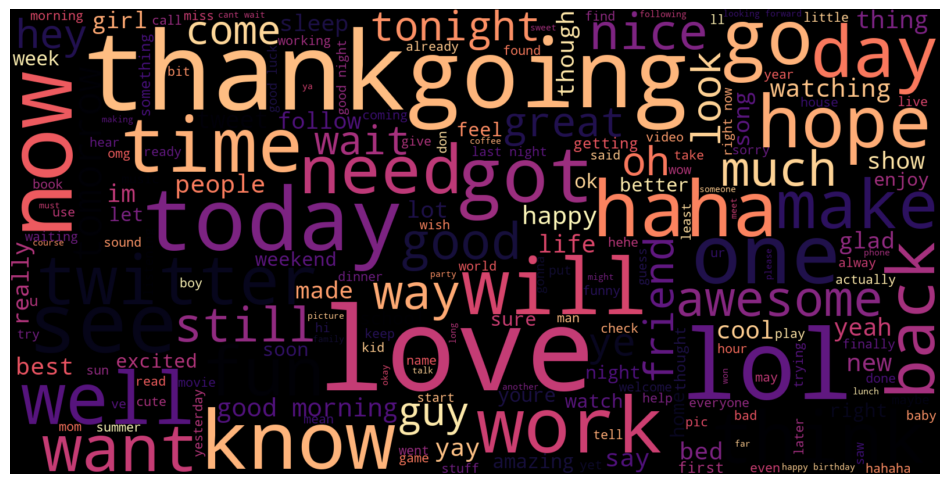

In [57]:
positive_text = []

def add_to_list(tweet):
    for word in tweet.split():
        positive_text.append(word)
        
df[df['target']==4].tweet_text.apply(lambda x:add_to_list(x))

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(' '.join(positive_text))

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

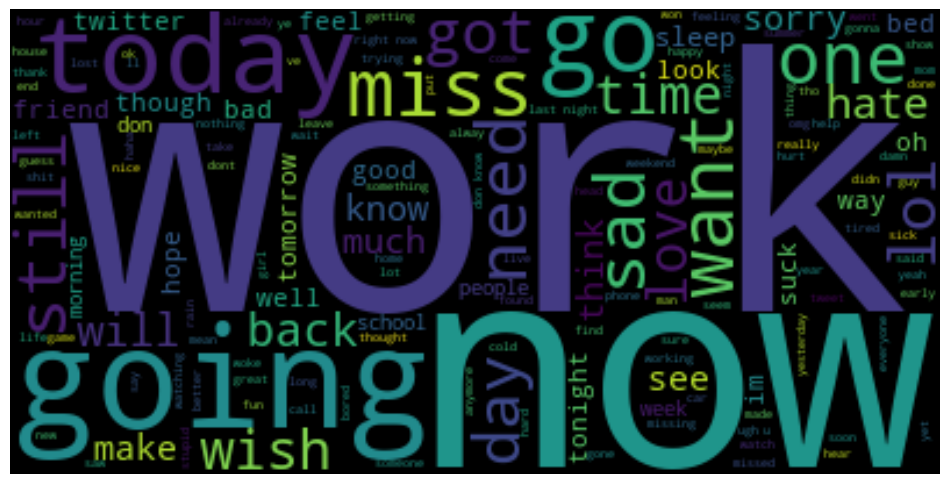

In [58]:
negative_text = []

def add_to_list(tweet):
    for word in tweet.split():
        negative_text.append(word)
        
df[df['target']==0].tweet_text.apply(lambda x:add_to_list(x))

wordcloud = WordCloud().generate(' '.join(negative_text))

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

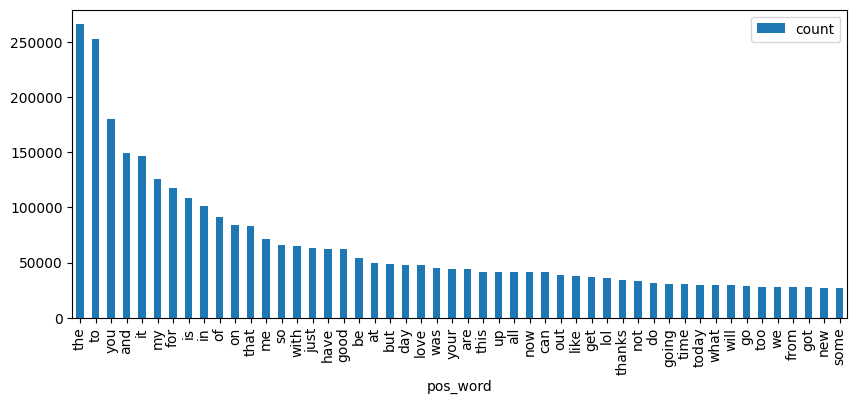

In [59]:
pos_count = {}
for word in positive_text:
    if word not in pos_count:
        pos_count[word] = 1
    elif word in pos_count:
        pos_count[word] += 1
# print(pos_count)

# https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
pos_term_df = pd.DataFrame(pos_count.items(),columns=['pos_word','count']).sort_values(by='count',ascending=False)
pos_term_df[:50].plot(x='pos_word',kind='bar',figsize=(10,4))
plt.show()

<AxesSubplot: xlabel='neg_word'>

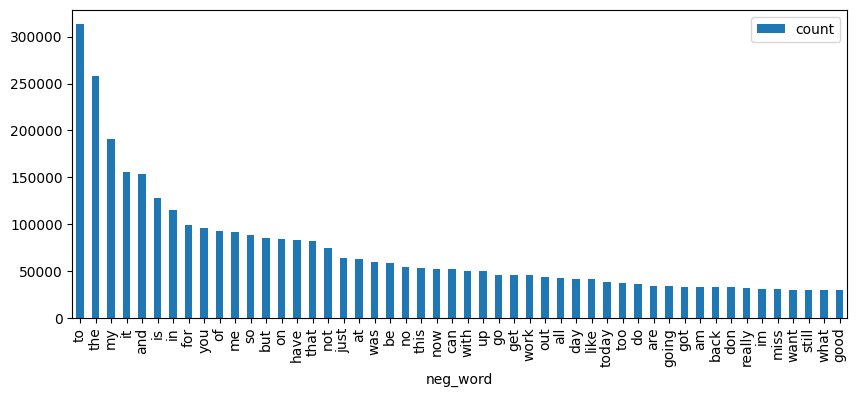

In [162]:
neg_count = {}
for word in negative_text:
    if word not in neg_count:
        neg_count[word] = 1
    elif word in neg_count:
        neg_count[word] += 1
# print(neg_count)

neg_term_df = pd.DataFrame(neg_count.items(),columns=['neg_word','count']).sort_values(by='count',ascending=False)
neg_term_df[:50].plot(x='neg_word',kind='bar',figsize=(10,4))

# Feature Extraction and summarization : 

In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
cvec = CountVectorizer()
cvec.fit(df.tweet_text)

# cvec - count vectorizer
neg_matrix = cvec.transform(df[df.target == 0].tweet_text)
pos_matrix = cvec.transform(df[df.target == 4].tweet_text)

neg_df = np.sum(neg_matrix,axis=0)
pos_df = np.sum(pos_matrix,axis=0)

negative = np.squeeze(np.asarray(neg_df))
positive = np.squeeze(np.asarray(pos_df))

term_freq = pd.DataFrame([negative,positive],columns=cvec.get_feature_names_out()).transpose()

# token and its occurance in both classes (0-negative, 1-positive)
term_freq.head()

0   1
aa      159  96
aaa      92  54
aaaa     43  29
aaaaa    26  12
aaaaaa   16  12

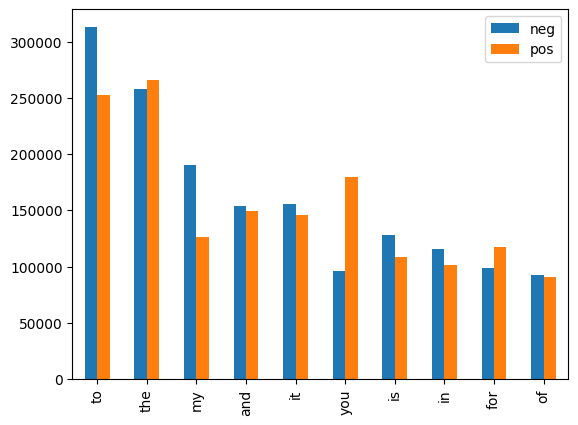

In [61]:
# renaming the columns
term_freq.columns = ['neg','pos']

# a df with index as tokens and columns as occurance of token (in both target strings)
term_freq['total_count'] = term_freq['neg'] + term_freq['pos']

term_freq.sort_values(by='total_count', ascending=False).iloc[:10][['neg','pos']].plot(kind='bar')
plt.show()

<!--  -->

### It is clear from this plot that the most common words associated with both positive and negative tweets are words that contain no meaning (including stop words).  This could affect the model we intend to train.

# Removing stopwords and setting max_features to 10,000 

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(df.tweet_text)

CountVectorizer(max_features=10000, stop_words='english')

In [74]:
# cvec - count vectorizer
neg_matrix_1 = cvec.transform(df[df.target == 0].tweet_text)
pos_matrix_1 = cvec.transform(df[df.target == 4].tweet_text)

neg_df_1 = np.sum(neg_matrix_1,axis=0)
pos_df_1 = np.sum(pos_matrix_1,axis=0)

negative_1 = np.squeeze(np.asarray(neg_df_1))
positive_1 = np.squeeze(np.asarray(pos_df_1))

term_freq_1 = pd.DataFrame([negative_1,positive_1],columns=cvec.get_feature_names_out()).transpose()

# token and its occurance in both classes (0-negative, 1-positive)
term_freq_1.head()

0   1
aa      159  96
aaa      92  54
aaaa     43  29
aaaah    76  61
aaaand   33  37

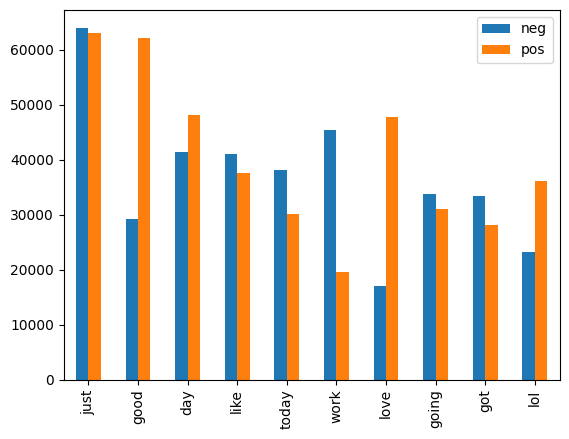

In [75]:
# renaming the columns
term_freq_1.columns = ['neg','pos']

# a df with index as tokens and columns as occurance of token (in both target strings)
term_freq_1['total_count'] = term_freq_1['neg'] + term_freq_1['pos']

term_freq_1.sort_values(by='total_count', ascending=False).iloc[:10][['neg','pos']].plot(kind='bar')
plt.show()

## removing the stopwords made some improvements to the plot. It would also be better to remove the top 10-15 words found from the previous plot that wasnt included in the stopwords although there is a high probability that the stopwords from sklearn should contain all those words

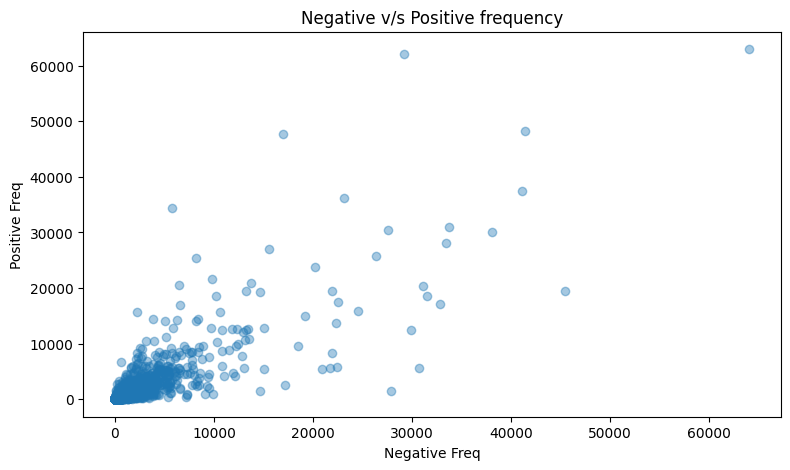

In [76]:
# https://seaborn.pydata.org/generated/seaborn.regplot.html
plt.figure(figsize=(9,5))
ax = sns.regplot(x="neg", y="pos",fit_reg=False, scatter_kws={'alpha':0.4},data=term_freq_1)
plt.ylabel('Positive Freq')
plt.xlabel('Negative Freq')
plt.title('Negative v/s Positive frequency')
plt.show()

## This plot isnt meaningful and there is no clear distinction between the positive and negative terms frequency. 
## We need to use some kind of metric that can detect important tokens from each class. 

## https://arxiv.org/pdf/1703.00565.pdf

### The intuition is that if a word if found more number of times in a class than the other class, then that word describes the fomer class better. 
### The equation would be :
###                    rate = class 1 freq / (class 1 freq + class 2 freq)

In [77]:
term_freq_1['total'] = term_freq_1['pos'] + term_freq_1['neg']

term_freq_1['pos_rate'] = term_freq_1['pos'] * 1./term_freq_1['total']
term_freq_1.sort_values(by='pos_rate', ascending=False).iloc[:10]

neg  pos  total_count  total  pos_rate
emailunlimited    0  100          100    100  1.000000
mileymonday       0  161          161    161  1.000000
dividends         0   83           83     83  1.000000
shareholder       1   80           81     81  0.987654
fuzzball          2   99          101    101  0.980198
recommends        3  109          112    112  0.973214
atcha             3   84           87     87  0.965517
delongeday        6  162          168    168  0.964286
timestamp         3   68           71     71  0.957746
shaundiviney      4   89           93     93  0.956989

In [78]:
# same for the negative class 
term_freq_1['neg_rate'] = term_freq_1['neg'] * 1./term_freq_1['total']

### Adding on to this: frequency of a word in its own class. 
### freq_pct = freq in class / class frequency 

In [79]:
term_freq_1['pos_freq_pct'] = term_freq_1['pos'] * 1./term_freq_1['pos'].sum()
term_freq_1['neg_freq_pct'] = term_freq_1['neg'] * 1./term_freq_1['neg'].sum()
term_freq_1.head()

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
aa      159   96          255    255  0.376471  0.623529      0.000022   
aaa      92   54          146    146  0.369863  0.630137      0.000012   
aaaa     43   29           72     72  0.402778  0.597222      0.000007   
aaaah    76   61          137    137  0.445255  0.554745      0.000014   
aaaand   33   37           70     70  0.528571  0.471429      0.000008   

        neg_freq_pct  
aa          0.000034  
aaa         0.000020  
aaaa        0.000009  
aaaah       0.000016  
aaaand      0.000007

### Issue with this is that first metric is more dominant and the second metric might lose its value.
### To resolve this I will try both/either of min-max normaliazation and z-score normalization.

In [80]:
# min-max :
term_freq_1['pos_rate_norm'] = (term_freq_1['pos_rate'] - term_freq_1['pos_rate'].min()) / (term_freq_1['pos_rate'].max() - term_freq_1['pos_rate'].min())
term_freq_1['pos_freq_norm'] = (term_freq_1['pos_freq_pct'] - term_freq_1['pos_freq_pct'].min()) / (term_freq_1['pos_freq_pct'].max() - term_freq_1['pos_freq_pct'].min())

term_freq_1['neg_rate_norm'] = (term_freq_1['neg_rate'] - term_freq_1['neg_rate'].min()) / (term_freq_1['neg_rate'].max() - term_freq_1['neg_rate'].min())
term_freq_1['neg_freq_norm'] = (term_freq_1['neg_freq_pct'] - term_freq_1['neg_freq_pct'].min()) / (term_freq_1['neg_freq_pct'].max() - term_freq_1['neg_freq_pct'].min())

In [81]:
# term_freq_1.drop(['pos_rate_norm' ,'pos_freq_pct' ,'neg_rate_norm' ,'neg_freq_pct'],axis=1,inplace=True)

### The difference between the two metrics were too big for min-max or z-score to work

### Moving on to harmonic mean, that combines both values to form 1 single metric.

In [82]:
term_freq_1

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
aa      159   96          255    255  0.376471  0.623529      0.000022   
aaa      92   54          146    146  0.369863  0.630137      0.000012   
aaaa     43   29           72     72  0.402778  0.597222      0.000007   
aaaah    76   61          137    137  0.445255  0.554745      0.000014   
aaaand   33   37           70     70  0.528571  0.471429      0.000008   
...     ...  ...          ...    ...       ...       ...           ...   
zune     87   57          144    144  0.395833  0.604167      0.000013   
zzz      87   96          183    183  0.524590  0.475410      0.000022   
zzzz     53   65          118    118  0.550847  0.449153      0.000015   
zzzzz    44   45           89     89  0.505618  0.494382      0.000010   
zzzzzz   30   44           74     74  0.594595  0.405405      0.000010   

        neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  \
aa          0.000034       0.376471       0.001525       0.623529   
aaa         0.000020       0.369863       0.000858       0.630137   
aaaa        0.000009       0.402778       0.000461       0.597222   
aaaah       0.000016       0.445255       0.000969       0.554745   
aaaand      0.000007       0.528571       0.000588       0.471429   
...              ...            ...            ...            ...   
zune        0.000019       0.395833       0.000906       0.604167   
zzz         0.000019       0.524590       0.001525       0.475410   
zzzz        0.000011       0.550847       0.001033       0.449153   
zzzzz       0.000009       0.505618       0.000715       0.494382   
zzzzzz      0.000006       0.594595       0.000699       0.405405   

        neg_freq_norm  
aa           0.002484  
aaa          0.001437  
aaaa         0.000672  
aaaah        0.001187  
aaaand       0.000516  
...               ...  
zune         0.001359  
zzz          0.001359  
zzzz         0.000828  
zzzzz        0.000687  
zzzzzz       0.000469  

[10000 rows x 12 columns]

In [83]:
# add small constant to avoid division by zero
constant = 1e-10

# harmonic mean
term_freq_1['pos_harmonic_mean'] = hmean(term_freq_1[['pos_rate', 'pos_freq_pct']].replace(0, constant), axis=1)
term_freq_1['neg_harmonic_mean'] = hmean(term_freq_1[['neg_rate', 'neg_freq_pct']].replace(0, constant), axis=1)
term_freq_1.sort_values(by='pos_harmonic_mean',ascending=False).iloc[:10]

neg    pos  total_count   total  pos_rate  neg_rate  pos_freq_pct  \
just    64002  62940       126942  126942  0.495817  0.504183      0.014258   
good    29206  62099        91305   91305  0.680127  0.319873      0.014067   
day     41371  48174        89545   89545  0.537986  0.462014      0.010913   
love    16990  47689        64679   64679  0.737318  0.262682      0.010803   
like    41049  37519        78568   78568  0.477535  0.522465      0.008499   
lol     23118  36102        59220   59220  0.609625  0.390375      0.008178   
thanks   5768  34374        40142   40142  0.856310  0.143690      0.007787   
going   33689  30939        64628   64628  0.478724  0.521276      0.007009   
time    27524  30426        57950   57950  0.525039  0.474961      0.006892   
today   38111  30093        68204   68204  0.441220  0.558780      0.006817   

        neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  \
just        0.013765       0.495817       1.000000       0.504183   
good        0.006281       0.680127       0.986638       0.319873   
day         0.008898       0.537986       0.765396       0.462014   
love        0.003654       0.737318       0.757690       0.262682   
like        0.008829       0.477535       0.596107       0.522465   
lol         0.004972       0.609625       0.573594       0.390375   
thanks      0.001241       0.856310       0.546139       0.143690   
going       0.007246       0.478724       0.491563       0.521276   
time        0.005920       0.525039       0.483413       0.474961   
today       0.008197       0.441220       0.478122       0.558780   

        neg_freq_norm  pos_harmonic_mean  neg_harmonic_mean  
just         1.000000           0.027718           0.026799  
good         0.456329           0.027564           0.012321  
day          0.646402           0.021392           0.017459  
love         0.265460           0.021294           0.007208  
like         0.641371           0.016701           0.017364  
lol          0.361207           0.016140           0.009819  
thanks       0.090122           0.015433           0.002460  
going        0.526374           0.013815           0.014293  
time         0.430049           0.013606           0.011694  
today        0.595466           0.013426           0.016156

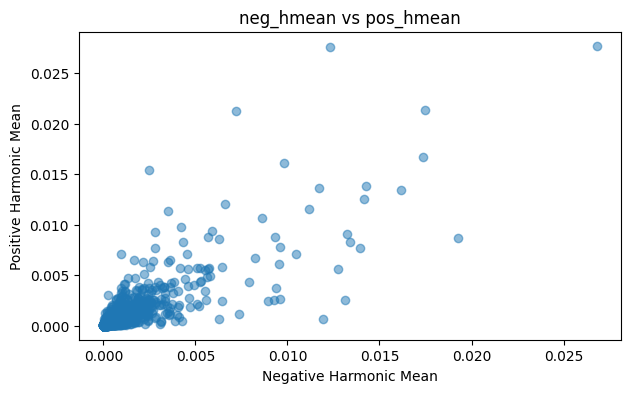

In [84]:
plt.figure(figsize=(7,4))
ax = sns.regplot(x="neg_harmonic_mean", 
                 y="pos_harmonic_mean",
                 fit_reg=False, 
                 scatter_kws={'alpha':0.5},
                 data=term_freq_1)
plt.ylabel('Positive Harmonic Mean')
plt.xlabel('Negative Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')
plt.show()

## I am still not able to find a seperation between the 2 classes. 
## Lets perform CDF : 

In [86]:
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_1['pos_rate_normcdf'] = normcdf(term_freq_1['pos_rate'])
term_freq_1['pos_freq_pct_normcdf'] = normcdf(term_freq_1['pos_freq_pct'])
term_freq_1['pos_normcdf_hmean'] = hmean([term_freq_1['pos_rate_normcdf'], term_freq_1['pos_freq_pct_normcdf']])

term_freq_1.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

neg    pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
welcome   620   6702         7322   7322  0.915324  0.084676      0.001518   
thank    2282  15733        18015  18015  0.873328  0.126672      0.003564   
thanks   5768  34374        40142  40142  0.856310  0.143690      0.007787   
awesome  3821  14468        18289  18289  0.791077  0.208923      0.003277   
glad     2273   8255        10528  10528  0.784100  0.215900      0.001870   
follow   2551   9154        11705  11705  0.782059  0.217941      0.002074   
enjoy    1642   5876         7518   7518  0.781591  0.218409      0.001331   
sweet    1610   5644         7254   7254  0.778053  0.221947      0.001279   
yay      3165  10501        13666  13666  0.768403  0.231597      0.002379   
hello    1122   4524         5646   5646  0.801275  0.198725      0.001025   

         neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  \
welcome      0.000133       0.915324       0.106482       0.084676   
thank        0.000491       0.873328       0.249968       0.126672   
thanks       0.001241       0.856310       0.546139       0.143690   
awesome      0.000822       0.791077       0.229870       0.208923   
glad         0.000489       0.784100       0.131157       0.215900   
follow       0.000549       0.782059       0.145440       0.217941   
enjoy        0.000353       0.781591       0.093359       0.218409   
sweet        0.000346       0.778053       0.089673       0.221947   
yay          0.000681       0.768403       0.166841       0.231597   
hello        0.000241       0.801275       0.071878       0.198725   

         neg_freq_norm  pos_harmonic_mean  neg_harmonic_mean  \
welcome       0.009687           0.003031           0.000266   
thank         0.035655           0.007099           0.000978   
thanks        0.090122           0.015433           0.002460   
awesome       0.059701           0.006528           0.001637   
glad          0.035515           0.003731           0.000976   
follow        0.039858           0.004136           0.001095   
enjoy         0.025655           0.002658           0.000705   
sweet         0.025155           0.002553           0.000691   
yay           0.049452           0.004743           0.001357   
hello         0.017531           0.002047           0.000482   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
welcome          0.995634              0.999371           0.997499  
thank            0.990810              1.000000           0.995384  
thanks           0.987797              1.000000           0.993861  
awesome          0.967100              1.000000           0.983275  
glad             0.963740              0.999972           0.981522  
follow           0.962706              0.999996           0.980997  
enjoy            0.962465              0.997443           0.979642  
sweet            0.960606              0.996321           0.978138  
yay              0.955150              1.000000           0.977060  
hello            0.971547              0.982276           0.976882

In [87]:
term_freq_1.head(1)

neg  pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
aa  159   96          255    255  0.376471  0.623529      0.000022   

    neg_freq_pct  pos_rate_norm  pos_freq_norm  neg_rate_norm  neg_freq_norm  \
aa      0.000034       0.376471       0.001525       0.623529       0.002484   

    pos_harmonic_mean  neg_harmonic_mean  pos_rate_normcdf  \
aa           0.000043           0.000068          0.220152   

    pos_freq_pct_normcdf  pos_normcdf_hmean  
aa              0.429376           0.291067

In [88]:
# cumulative distribution function
def cumulative_distribution_function(value):
    return norm.cdf(value, value.mean(), value.std())

# cdf for pos
term_freq_1['norm_pos_rate_cdf'] = cumulative_distribution_function(term_freq_1['pos_rate'])
term_freq_1['norm_pos_frequency_cdf'] = cumulative_distribution_function(term_freq_1['pos_freq_pct'])

# cdf for neg
term_freq_1['norm_neg_rate_cdf'] = cumulative_distribution_function(term_freq_1['neg_rate'])
term_freq_1['norm_neg_frequency_cdf'] = cumulative_distribution_function(term_freq_1['neg_freq_pct'])

# harmonic mean of new columns:
term_freq_1['pos_harmonic_mean_norm_cdf'] = hmean([term_freq_1['norm_pos_rate_cdf'], term_freq_1['norm_pos_frequency_cdf']])
term_freq_1['neg_harmonic_mean_norm_cdf'] = hmean([term_freq_1['norm_neg_rate_cdf'], term_freq_1['norm_neg_frequency_cdf']])

# sort by harmonic mean 
term_freq_1.sort_values(by='pos_harmonic_mean_norm_cdf', ascending=False).iloc[:10]

neg    pos  total_count  total  pos_rate  neg_rate  pos_freq_pct  \
welcome   620   6702         7322   7322  0.915324  0.084676      0.001518   
thank    2282  15733        18015  18015  0.873328  0.126672      0.003564   
thanks   5768  34374        40142  40142  0.856310  0.143690      0.007787   
awesome  3821  14468        18289  18289  0.791077  0.208923      0.003277   
glad     2273   8255        10528  10528  0.784100  0.215900      0.001870   
follow   2551   9154        11705  11705  0.782059  0.217941      0.002074   
enjoy    1642   5876         7518   7518  0.781591  0.218409      0.001331   
sweet    1610   5644         7254   7254  0.778053  0.221947      0.001279   
yay      3165  10501        13666  13666  0.768403  0.231597      0.002379   
hello    1122   4524         5646   5646  0.801275  0.198725      0.001025   

         neg_freq_pct  pos_rate_norm  pos_freq_norm  ...  neg_harmonic_mean  \
welcome      0.000133       0.915324       0.106482  ...           0.000266   
thank        0.000491       0.873328       0.249968  ...           0.000978   
thanks       0.001241       0.856310       0.546139  ...           0.002460   
awesome      0.000822       0.791077       0.229870  ...           0.001637   
glad         0.000489       0.784100       0.131157  ...           0.000976   
follow       0.000549       0.782059       0.145440  ...           0.001095   
enjoy        0.000353       0.781591       0.093359  ...           0.000705   
sweet        0.000346       0.778053       0.089673  ...           0.000691   
yay          0.000681       0.768403       0.166841  ...           0.001357   
hello        0.000241       0.801275       0.071878  ...           0.000482   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  \
welcome          0.995634              0.999371           0.997499   
thank            0.990810              1.000000           0.995384   
thanks           0.987797              1.000000           0.993861   
awesome          0.967100              1.000000           0.983275   
glad             0.963740              0.999972           0.981522   
follow           0.962706              0.999996           0.980997   
enjoy            0.962465              0.997443           0.979642   
sweet            0.960606              0.996321           0.978138   
yay              0.955150              1.000000           0.977060   
hello            0.971547              0.982276           0.976882   

         norm_pos_rate_cdf  norm_pos_frequency_cdf  norm_neg_rate_cdf  \
welcome           0.995634                0.999371           0.004366   
thank             0.990810                1.000000           0.009190   
thanks            0.987797                1.000000           0.012203   
awesome           0.967100                1.000000           0.032900   
glad              0.963740                0.999972           0.036260   
follow            0.962706                0.999996           0.037294   
enjoy             0.962465                0.997443           0.037535   
sweet             0.960606                0.996321           0.039394   
yay               0.955150                1.000000           0.044850   
hello             0.971547                0.982276           0.028453   

         norm_neg_frequency_cdf  pos_harmonic_mean_norm_cdf  \
welcome                0.531566                    0.997499   
thank                  0.823368                    0.995384   
thanks                 0.996628                    0.993861   
awesome                0.956783                    0.983275   
glad                   0.822174                    0.981522   
follow                 0.856721                    0.980997   
enjoy                  0.726186                    0.979642   
sweet                  0.720717                    0.978138   
yay                    0.916111                    0.977060   
hello                  0.631438                    0.976882   

         neg

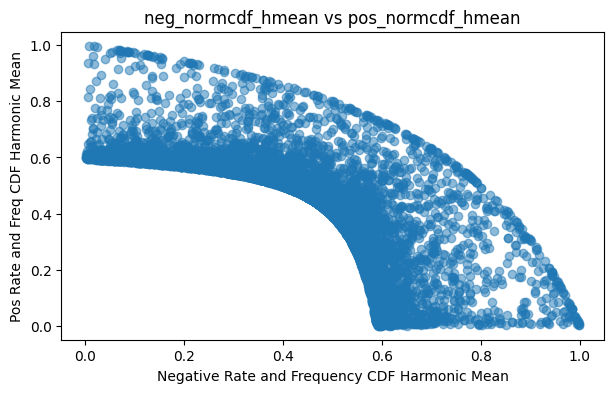

In [89]:
plt.figure(figsize=(7,4))
ax = sns.regplot(x="neg_harmonic_mean_norm_cdf", y="pos_harmonic_mean_norm_cdf",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_1)
plt.ylabel('Pos Rate and Freq CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

plt.show()

In [90]:
fig = px.scatter(term_freq_1, 
                 x="neg_harmonic_mean_norm_cdf", 
                 y="pos_harmonic_mean_norm_cdf", 
                 hover_data=[term_freq_1.index])

fig.update_layout(
    title='Neg NormCDF Harmonic Mean vs Pos NormCDF Harmonic Mean',
    xaxis=dict(title='Negative Rate and Frequency CDF Harmonic Mean'),
    yaxis=dict(title='Pos Rate and Freq CDF Harmonic Mean'),
    hovermode="closest")

fig.show()

## Going through the plot, it is clear that there is a pattern formed where at the top of the curve towards the left it is almost all positive but towards the bottom right its all negative words.